# Exploratory Data Analysis

In [136]:
import pandas as pd
import geopandas as gpd
import numpy as np
from datetime import date
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing

### Create definitions for the following functions:

In [137]:
"""
Function to consistently create a well ID (WID) column
"""
def create_WID(df, col_name):
    
    df['WID'] = df['GLOBAL_ID'] + '-' + df[col_name]
    return df

### Load the data

In [138]:
# Load depth to groundwater data
geo_well = pd.read_csv('data/LosAngelesGeoWell.txt', sep='\t', encoding='unicode_escape')

# Convert date to datetime
geo_well['GW_MEAS_DATE'] = pd.to_datetime(geo_well['GW_MEAS_DATE'],format='%Y-%m-%d', errors='coerce')

# Create a mask for any rows with dates past the current date and drop them.
mask = geo_well['GW_MEAS_DATE'] >= str(date.today())
geo_well = geo_well[~mask]

# Create a mask for any rows with dates before the specified date (01-01-2000) and drop them.
mask = geo_well['GW_MEAS_DATE'] <= '01-01-2000'
geo_well = geo_well[~mask]

# Drop any rows with null values for GW_MEAS_DATE and reset the index.
geo_well.dropna(subset=['GW_MEAS_DATE'], inplace=True)
geo_well.reset_index(drop=True, inplace=True)

# Fill NaNs with 0 for the DTFPROD and DTW columns.
geo_well['DTFPROD'].fillna(0, inplace=True)
geo_well['DTW'].fillna(0, inplace=True)

# Create a new column for the total depth to groundwater.
geo_well['DEPTH'] = np.nan

# Create mask for rows with DTFPROD == 0 then sets DEPTH equal to DTW.
mask = geo_well['DTFPROD'] == 0
geo_well.loc[mask, 'DEPTH'] = geo_well['DTW']

# Create maks for rows with DTW == 0 then sets DEPTH equal to DTFPROD.
mask = geo_well['DTW'] == 0
geo_well.loc[mask, 'DEPTH'] = geo_well['DTFPROD']

# Create a mask for rows with DTFPROD != 0 and DTW != 0 then sets DEPTH equal to DTW.
mask = (geo_well['DTW'] != 0) & (geo_well['DTFPROD'] != 0)
geo_well.loc[mask, 'DEPTH'] = geo_well['DTW']

# Create mask for rows with depth of 0 and drop them.
mask = geo_well['DEPTH'] == 0
geo_well = geo_well[~mask]

# Create a WID column.
geo_well = create_WID(geo_well, 'FIELD_POINT_NAME')
geo_well['GID'] = geo_well['WID'] + ':' + geo_well['GW_MEAS_DATE'].astype(str)

c:\Users\chief\.conda\envs\geoprj\lib\site-packages\IPython\core\interactiveshell.py:3398: DtypeWarning: Columns (3,4,7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [139]:
# Load the top of well elevation data.
geo_z = pd.read_csv('data/LosAngelesGeoZ.txt', sep='\t', encoding='unicode_escape', on_bad_lines='warn')

# Fill in NaN values with 0
geo_z['RISER_HT'].fillna(0, inplace=True)

# Remove invalid rows
geo_z.drop(geo_z[geo_z['RISER_HT'] == '2009-12-18'].index, inplace=True)

# Add RISER_HT to the ELEVATION column to get true well casing elevation (where depth to water is measured from).
geo_z['ELEVATION'] = geo_z['ELEVATION'] + geo_z['RISER_HT'].astype(float)

# Remove rows with invalid ELEVATION values
geo_z.dropna(subset=['ELEVATION'], inplace=True)

# Create WID column.
geo_z = create_WID(geo_z, 'FIELD_PT_NAME')

# Keep only requied columns.
geo_z = geo_z[['WID', 'ELEVATION']]

b'Skipping line 211619: expected 12 fields, saw 20\n'
c:\Users\chief\.conda\envs\geoprj\lib\site-packages\IPython\core\interactiveshell.py:3398: DtypeWarning: Columns (2,5,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [140]:
# Load the well location data.
geo_xy = pd.read_csv('data/LosAngelesGeoXY.txt', sep='\t', encoding='unicode_escape', on_bad_lines='warn')

# Create WID column.
geo_xy = create_WID(geo_xy, 'FIELD_PT_NAME')

# Create mask for rows with NaN X and Y values and drop them.
mask = (geo_xy['LATITUDE'].isna()) | (geo_xy['LONGITUDE'].isna())
geo_xy = geo_xy[~mask]

# Create mask for rows with latitude and longitude in NAD83 and keep them.
mask = geo_xy['XY_DATUM'] == 'NAD83'
geo_xy = geo_xy[mask]

# Reset the index.
geo_xy.reset_index(drop=True, inplace=True)

# Keep only required columns.
geo_xy = geo_xy[['WID', 'LONGITUDE', 'LATITUDE']]

b'Skipping line 18923: expected 13 fields, saw 14\nSkipping line 19016: expected 13 fields, saw 14\n'
b'Skipping line 200273: expected 13 fields, saw 14\nSkipping line 200274: expected 13 fields, saw 14\nSkipping line 200275: expected 13 fields, saw 14\nSkipping line 200444: expected 13 fields, saw 14\nSkipping line 200445: expected 13 fields, saw 14\nSkipping line 200446: expected 13 fields, saw 14\nSkipping line 201921: expected 13 fields, saw 14\nSkipping line 201922: expected 13 fields, saw 14\nSkipping line 202073: expected 13 fields, saw 14\nSkipping line 202074: expected 13 fields, saw 14\nSkipping line 202075: expected 13 fields, saw 14\nSkipping line 202076: expected 13 fields, saw 14\nSkipping line 202396: expected 13 fields, saw 14\nSkipping line 202660: expected 13 fields, saw 14\nSkipping line 202901: expected 13 fields, saw 14\nSkipping line 202902: expected 13 fields, saw 14\nSkipping line 205043: expected 13 fields, saw 14\nSkipping line 205044: expected 13 fields, saw 

### Merge dataframes

In [141]:
# Create Pandas dataframe for the well data by merging the depth to water and well elevation data.
geo = pd.merge(geo_well, geo_z, on='WID', how='left')

# Merge the well data with the xy data.
geo = pd.merge(geo, geo_xy, on='WID', how='left')

# Drop NaNs from the ELEVATION column.
geo.dropna(subset=['ELEVATION'], inplace=True)

# Drop duplicate GID rows.
geo.drop_duplicates(subset=['GID'], inplace=True)

# Create WATER_ELEVATION column by subtracting the the depth to water from the well elevation.
geo['WATER_ELEVATION'] = geo['ELEVATION'] - geo['DEPTH']

# Drop NaNs from the WATER_ELEVATION, LATIDUTE, and LONGITUDE columns.
geo.dropna(subset=['WATER_ELEVATION','LATITUDE','LONGITUDE'], inplace=True)

# Sort values by date and then reset the index.
geo.sort_values(by=['GW_MEAS_DATE'], inplace=True)

# Create ZSCORE columns for DEPTH and WATER_ELEVATION and use them to remove outliers.
geo['ZSCORE_DEPTH'] =  stats.zscore(geo['DEPTH'])
geo['ZSCORE_WELEV'] =  stats.zscore(geo['WATER_ELEVATION'])

# Create a mask for rows with ZSCORE_DEPTH > 3 or ZSCORE_WELEV > 3 and drop them, then reset the index.
mask = (abs(geo['ZSCORE_WELEV']) >= 3)
geo = geo[~mask]
geo.reset_index(drop=True, inplace=True)

## Visualize the data

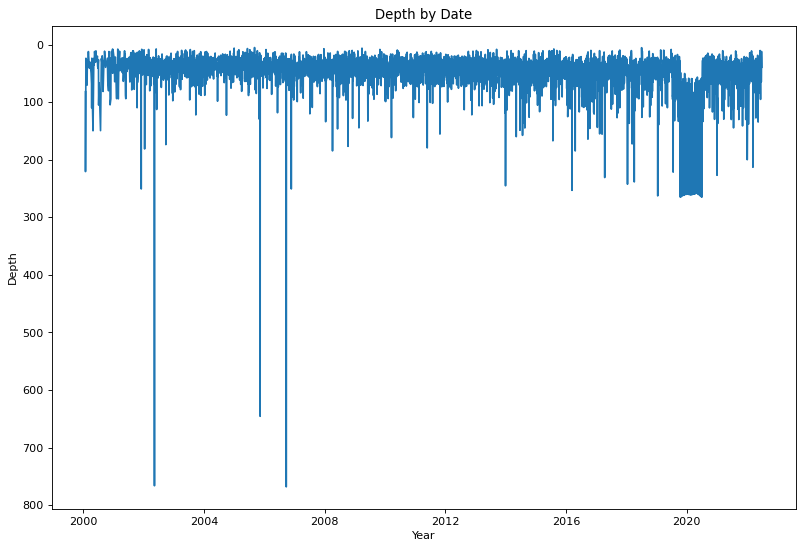

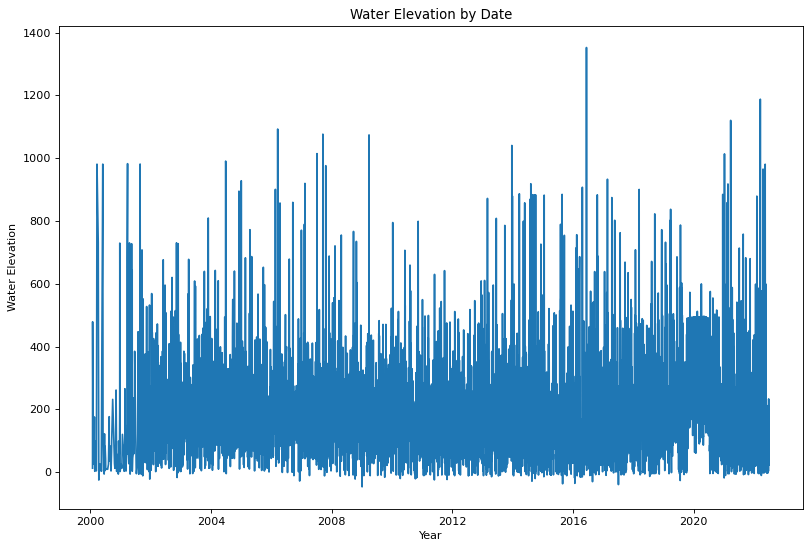

In [142]:
# Group values by date and plot the mean of the WATER_ELEVATION and DEPTH columns.
x_labels = []
x_ticks = []
for i in range(12):
    x_ticks.append(i*30.5)
    x_labels.append(str(i+1))

by_date = geo.groupby(['GW_MEAS_DATE']).mean().reset_index()
plt.figure(figsize=(12,8), dpi=80)
plt.plot(by_date['GW_MEAS_DATE'], by_date['DEPTH'])
plt.gca().invert_yaxis()
plt.xlabel('Year')
plt.ylabel('Depth')
plt.title('Depth by Date')
plt.show()

by_date = geo.groupby(['GW_MEAS_DATE']).mean().reset_index()
plt.figure(figsize=(12,8), dpi=80)
plt.plot(by_date['GW_MEAS_DATE'], by_date['WATER_ELEVATION'])
plt.xlabel('Year')
plt.ylabel('Water Elevation')
plt.title('Water Elevation by Date')
plt.show()

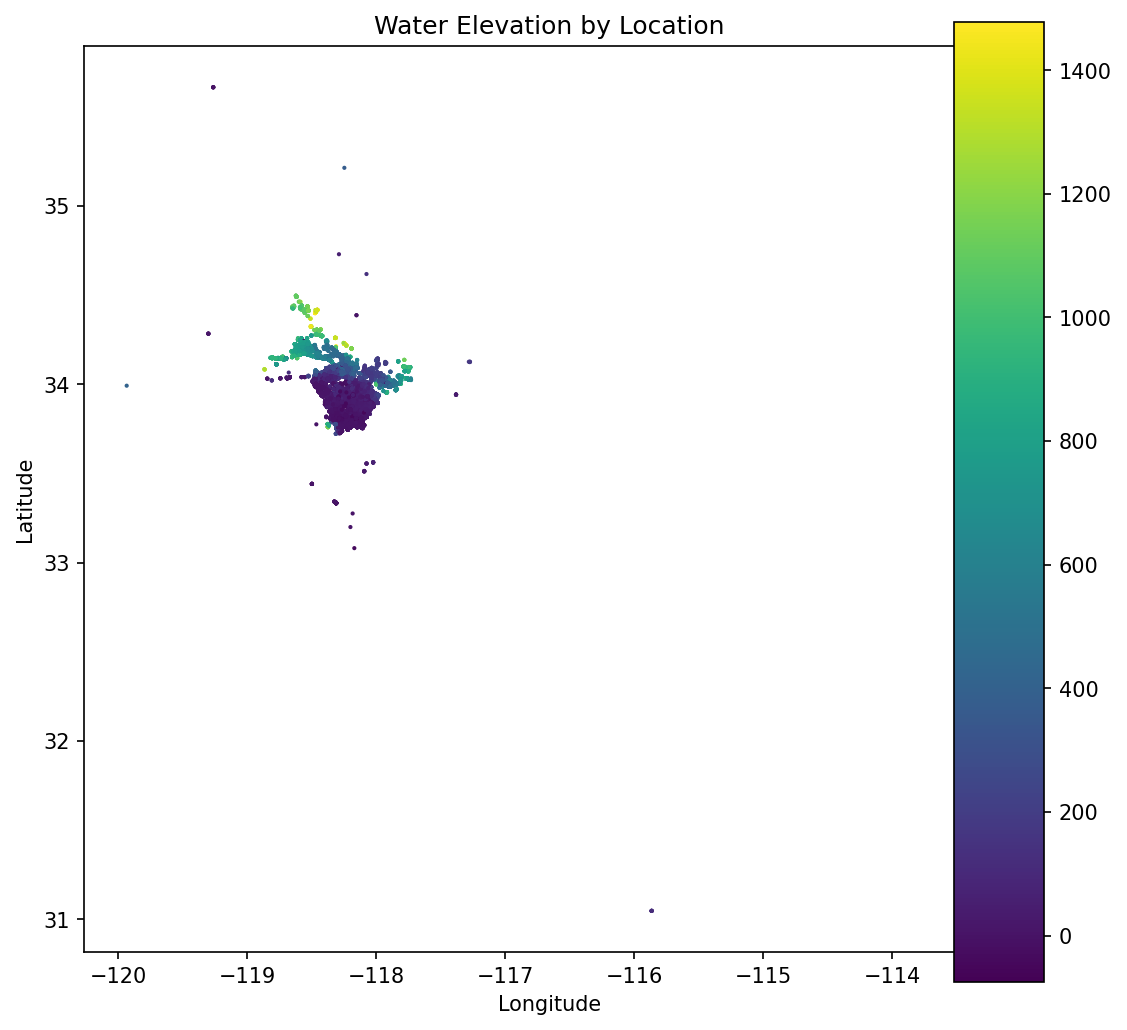

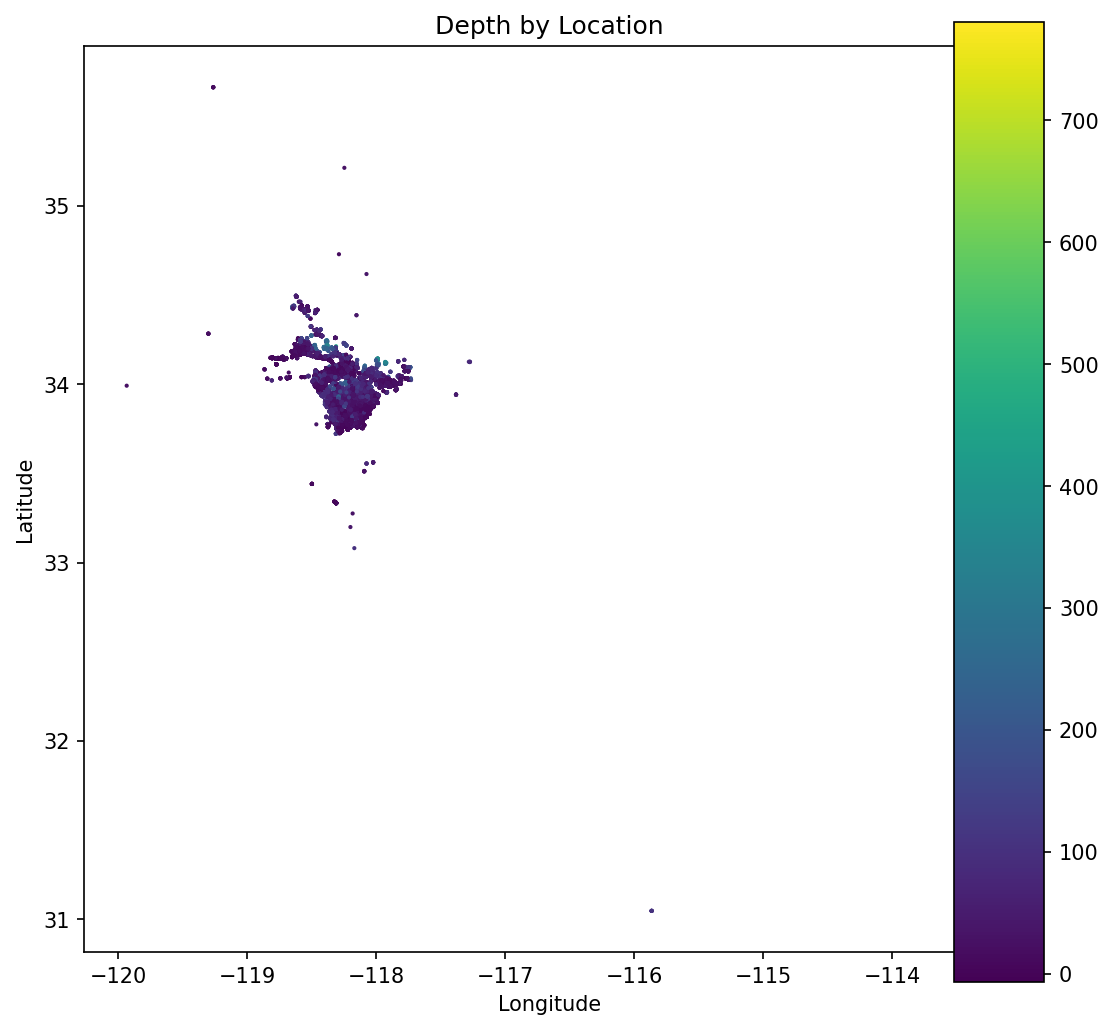

In [143]:
# Group values by well ID (WID) and plot the locations of wells and their mean of the WATER_ELEVATION and DEPTH columns.
by_wid = geo.groupby(['WID']).mean().reset_index()
by_wid = by_wid.merge(geo_xy, on='WID', how='left')

# Plot WATER_ELEVATION for each well.
plt.figure(figsize=(8,8), dpi=150)
plt.scatter(by_wid['LONGITUDE'], by_wid['LATITUDE'], c=by_wid['WATER_ELEVATION'], cmap='viridis', s=1)
plt.title('Water Elevation by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cbar = plt.colorbar(cax=plt.axes([0.85, 0.1, 0.075, 0.8]))
cbar.solids.set_edgecolor("face")

plt.show()

# Plot DEPTH for each well.
plt.figure(figsize=(8,8), dpi=150)
plt.scatter(by_wid['LONGITUDE'], by_wid['LATITUDE'], c=by_wid['DEPTH'], cmap='viridis', s=1)
plt.title('Depth by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cbar = plt.colorbar(cax=plt.axes([0.85, 0.1, 0.075, 0.8]))
cbar.solids.set_edgecolor("face")

plt.show()

## Model data

In [144]:
from collections import Counter

# Create a Counter object for the WID column.
counter = Counter(geo['WID'])

# Create a list of WID values that have 100 or more depth samples.
wids = []
for i in counter.items():
    if i[1] >= 100:
        wids.append(i[0])

### Linear Regression

The goal is to test the efficacy of using the date a sample is taken to predict the depth to groundwater at a specific well. I decided to only train the model on wells that have 100 or more total samples. I split the data randomly, train the model, run predictions and evalute them for each well 100 times. These evaluations are then averaged to get a better idea of the overall accuracy of the model. The average of these metrics for each well are put into a dataframe. With this we can get an idea of the accuracy of the model across the entire dataset.

In [145]:
import sklearn.linear_model as lm
import sklearn.model_selection as ms
import sklearn.metrics as metrics

In [153]:
# Load linear regression model.
model = lm.LinearRegression()

# Create blank dataframe for the evaluations.
blank = pd.DataFrame(columns=['WID','R2','ADJ_R2','MAE','MSE','RMSE'])

# Copy the blank dataframe to the results dataframe.
res = blank.copy()

# Set count for results dataframe.
res_count = 0
total = len(wids)

# Loop through the WID values. These have 100 or more depth samples.
for j in wids:
        try:
                # Create temp dataframe from the blank dataframe to store specific well evaluation results.
                tdf = blank.copy()

                # Set count for temp dataframe.
                tdf_count = 0

                # Create subset of the geo dataframe for the specific well.
                df = geo[geo['WID'] == j].copy()

                # Change date to numeric.
                df['GW_MEAS_DATE'] = pd.to_numeric(df['GW_MEAS_DATE'])

                # Sort Date values
                df.sort_values(by='GW_MEAS_DATE', inplace=True)

                # Create zscore for depth to water to remove outliers. Reset index.
                df['ZSCORE_WID_DEPTH'] = stats.zscore(geo['DEPTH'])
                mask = abs(df['ZSCORE_WID_DEPTH'] ) >= 3
                df = df[~mask]
                df.reset_index(drop=True, inplace=True)

                # Loop through model processing 200 times to get an average of the results.
                for n in range(200):

                        x_train, x_test, y_train, y_test = ms.train_test_split(
                                df['GW_MEAS_DATE'], df['DEPTH'], test_size=0.2
                                )

                        x_train = x_train.to_numpy().reshape(-1, 1)
                        x_test = x_test.to_numpy().reshape(-1, 1)
                        y_train = y_train.to_numpy()
                        y_test = y_test.to_numpy()

                        model.fit(x_train, y_train)

                        y_pred = model.predict(x_test)

                        r2 = metrics.r2_score(y_test, y_pred)
                        adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - x_train.shape[1] - 1)
                        mae = metrics.mean_absolute_error(y_test, y_pred)
                        mse = metrics.mean_squared_error(y_test, y_pred)
                        rmse = np.sqrt(mse)

                        tdf.loc[tdf_count] = [j, r2, adj_r2, mae, mse, rmse]
                        tdf_count += 1

                # Add the temp dataframe to the results dataframe.
                tdf = tdf.mean(numeric_only=True).to_frame().T.reset_index().rename(columns={'index':'WID'})
                tdf['WID'] = j
                res.loc[res_count] = tdf.loc[0]
                res_count += 1
                pct = res_count / total * 100
                if int(pct) % 5 == 0:
                        print(f'{pct:.2f}%')
        except:
                print(f'{j} failed')
                continue

0.80%
5.60%
10.40%
15.20%
20.00%
20.80%
25.60%
30.40%
35.20%
40.00%
40.80%
45.60%
50.40%
55.20%
60.00%
60.80%
65.60%
L10001359910-MW-1 failed
70.40%
75.20%
80.00%
80.80%
T10000004448-MW-6 failed
T10000004448-MW-9 failed
T10000004448-MW-15 failed
T10000004448-MW-22B failed
T10000004448-MW-22A failed
T10000004448-MW-3A failed
T10000004448-MW-25B failed
T10000004448-MW-15B failed
T10000004448-MW-25C failed
T10000004448-MW-19A failed
T10000004448-MW-24A failed
T10000004448-MW-19B failed
T10000004448-MW-24B failed
T10000004448-MW-23B failed
T10000004448-MW-23A failed
T10000004448-MW-20A failed
T10000004448-MW-30A failed
T10000004448-MW-30C failed
T10000004448-MW-30B failed
T10000004448-MW-29A failed
T10000004448-MW-29C failed


In [154]:
res.describe()

,R2,ADJ_R2,MAE,MSE,RMSE
count,103.000000,103.000000,103.000000,103.000000,103.000000
mean,0.264000,0.241302,3.471917,34.716328,4.405328
std,0.336289,0.344338,3.157549,48.704124,3.832969
min,-0.218468,-0.246805,0.142626,0.042030,0.202283
25%,0.000671,-0.018345,1.309548,2.760781,1.649514
50%,0.110850,0.081674,1.891994,6.850325,2.486649
75%,0.481571,0.458613,6.578622,71.251223,8.383869
max,0.977285,0.976411,12.838045,226.707152,15.029617


In [155]:
res = res.merge(geo_xy, on='WID', how='left')

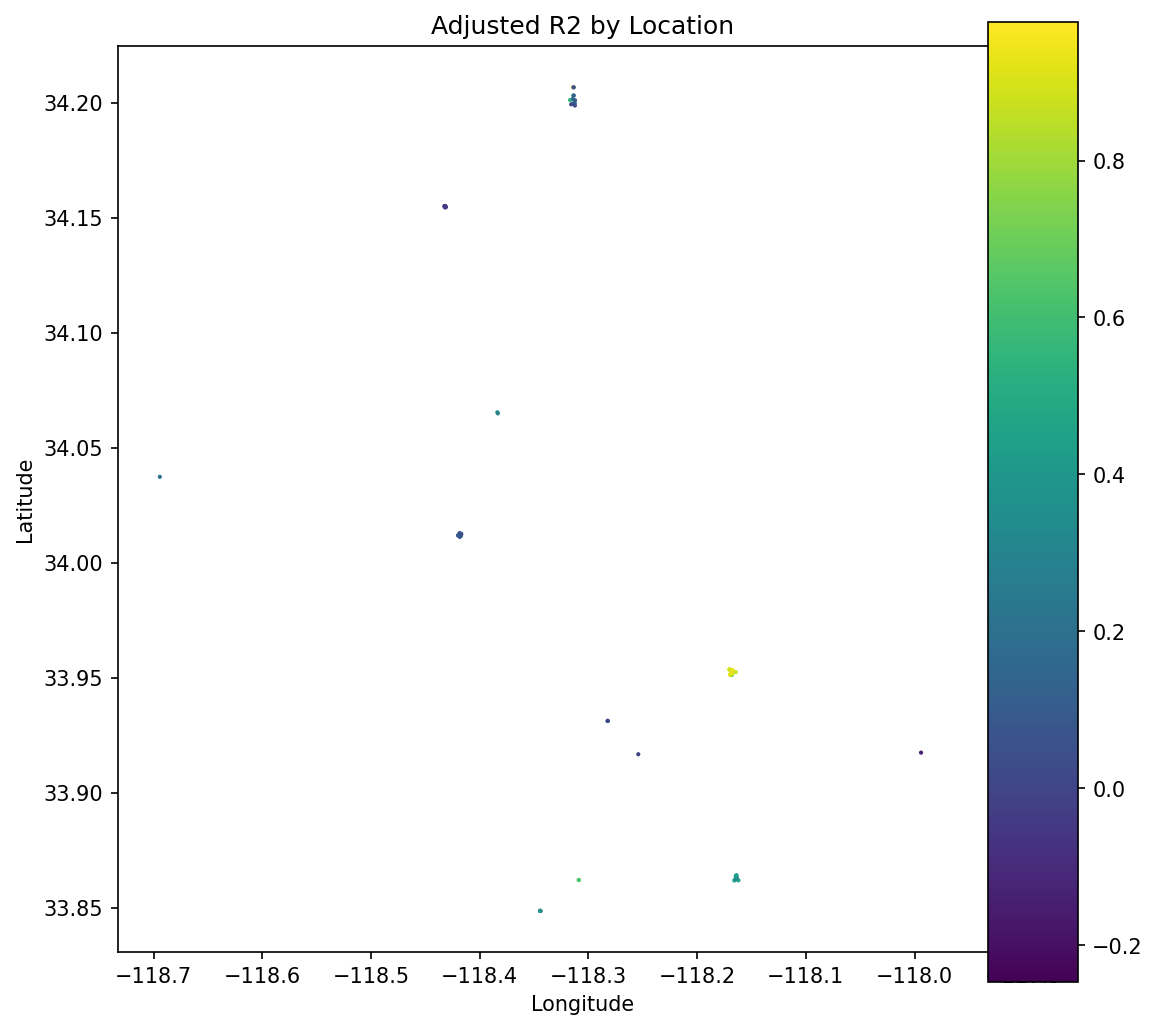

In [156]:
# Plot the results.
plt.figure(figsize=(8,8), dpi=150)
plt.scatter(res['LONGITUDE'],res['LATITUDE'], c=res['ADJ_R2'], cmap='viridis', s=1)
plt.title('Adjusted R2 by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cbar = plt.colorbar(cax=plt.axes([0.85, 0.1, 0.075, 0.8]))
cbar.solids.set_edgecolor("face")
plt.show()

## Discuss the results

With an average adjusted r2 of 0.26 we can see that the model is not very accurate. With an average RMSE of 4.41, we can estimate that our predictions are off by 4.4 feet on average. With an average depth of 43.62 feet, this is an average plus or minus error of over 10%, which is inadaquate for normalizing chemical concentrations. The model is not able to predict the depth to groundwater accurately with the date a sample is taken alone. The next step is to add more features to the model. Some features that could improve the model are:

1. Daily observed/estimated precipitation

2. Daily observed temperature

6. Daily observed solar radiation

7. Daily observed dew point temperature

9. Daily observed air pressure

10. Daily observed sea level pressure
